In [1]:
import openeo
from openeo.processes import *

# backend = "openeo.cloud"
backend = "https://openeo-dev.eodc.eu/openeo/1.1.0/"
conn = openeo.connect(backend)
conn = conn.authenticate_oidc()

Authenticated using refresh token.


In [2]:
conn.describe_collection("GFM")

{'type': 'Collection',
 'id': 'GFM',
 'stac_version': '1.0.0',
 'description': "The Global Flood Monitoring (GFM) product is a new component of the EU's Copernicus Emergency Management Service (CEMS) that provides continuous monitoring of floods worldwide, by processing and analysing in near real-time (NRT) all incoming Synthetic Aperture Radar (SAR) imagery acquired by the EU's Copernicus Sentinel-1 satellites, in Interferometric Wide Swath (IW) mode and as Ground Range Detected (GRD) products.",
 'links': [{'rel': 'items',
   'href': 'https://dev.stac.eodc.eu/api/v1/collections/GFM/items',
   'type': 'application/geo+json'},
  {'rel': 'parent',
   'href': 'https://dev.stac.eodc.eu/api/v1/',
   'type': 'application/json'},
  {'rel': 'root',
   'href': 'https://dev.stac.eodc.eu/api/v1/',
   'type': 'application/json'},
  {'rel': 'self',
   'href': 'https://dev.stac.eodc.eu/api/v1/collections/GFM',
   'type': 'application/json'}],
 'stac_extensions': ['https://stac-extensions.github.io/projection/v1.1.0/schema.json',
  'https://stac-extensions.github.io/eo/v1.1.0/schema.json',
  'https://stac-extensions.github.io/datacube/v2.2.0/schema.json',
  'https://stac-extensions.github.io/eo/v1.1.0/schema.json'],
 'cube:dimensions': {'x': {'axis': 'x',
   'type': 'spatial',
   'extent': [-180, 180]},
  'y': {'axis': 'y', 'type': 'spatial', 'extent': [-90, 90]},
  'time': {'type': 'temporal', 'extent': [['2015-01-01T00:00:00Z', None]]},
  'bands': {'type': 'bands', 'values': ['flood_extent', 'refwater']}},
 'title': 'Global Flood Monitoring',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2015-01-01T00:00:00Z', None]]}},
 'license': 'proprietary',
 'providers': [{'name': 'JRC CEMS',
   'roles': ['licensor'],
   'url': 'https://emergency.copernicus.eu/'},
  {'name': 'EODC', 'roles': ['processor', 'host'], 'url': 'https://eodc.eu/'}],
 'summaries': {'eo:bands': [{'name': 'flood_extent',
    'description': 'GFM observed flood extent'},
   {'name': 'refwater', 'description': 'GFM reference water mask'}],
  'platform': ['sentinel-1a', 'sentinel-1b'],
  'constellation': ['sentinel-1']}}

In [3]:
spatial_extent  = {'west': 67.5, 'east':70, 'south':24.5, 'north':26}
temporal_extent = ["2022-09-01", "2022-10-01"] 
collection      = 'GFM'

gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["flood_extent"]
)
gfm_sum = gfm_data.reduce_dimension(dimension="time", reducer=sum)

gfm_sum_nc = gfm_sum.save_result(format="NetCDF", options={"tile_grid": "equi7", "dtype": "int16"}) 

In [6]:
job = gfm_sum_nc.create_job(title = "UC11")
jobId = job.job_id
job.start_job()

<BatchJob job_id='63d1799f-8e23-410b-8fe0-c12f1e2e2654'>

In [7]:
job.status()

'finished'

In [8]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./gfm/flood_extent/")

[PosixPath('gfm/flood_extent/AS020M_E018N027T3_20220901T010907.nc'),
 PosixPath('gfm/flood_extent/AS020M_E015N027T3_20220901T010907.nc'),
 PosixPath('gfm/flood_extent/AS020M_E015N024T3_20220901T010907.nc'),
 PosixPath('gfm/flood_extent/AS020M_E018N024T3_20220901T010907.nc'),
 PosixPath('gfm/flood_extent/job-results.json')]

Maximum value:  10
Minimum value:  0


<xarray.DataArray 'flood_extent' (y: 11879, x: 14489)>
dask.array<concatenate, shape=(11879, 14489), dtype=int16, chunksize=(9506, 8967), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2.89e+06 2.89e+06 2.89e+06 ... 2.653e+06 2.653e+06
  * x            (x) float64 1.621e+06 1.621e+06 1.621e+06 ... 1.91e+06 1.91e+06
    time         datetime64[ns] 2022-09-01T01:09:07
    spatial_ref  int64 0

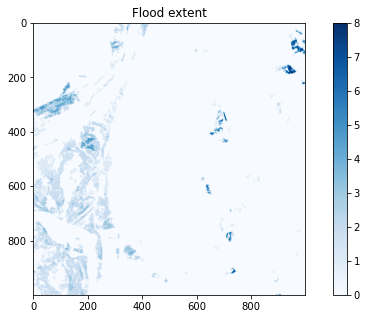

In [9]:
# really basic test to see if the results are actually as expected
import os
import xarray as xr
import matplotlib.pyplot as plt

path = "./gfm/flood_extent/"
files = [path + file for file in os.listdir(path) if file.startswith("AS020") and "20220901" in file]
D = xr.open_mfdataset(files)
d = D.flood_extent
print("Maximum value: ", d.max().values)
print("Minimum value: ", d.min().values)
display(d)
plt.figure(figsize=(10,5))
plt.title(f"Flood extent")
# only plot a part of the data
plt.imshow(d[5000:6000,5000:6000], cmap="Blues")
plt.colorbar()

In [10]:
spatial_extent  = {'west': 67.5, 'east':70, 'south':24.5, 'north':26}
temporal_extent = ["2022-09-01", "2022-10-01"] 
collection      = 'GFM'

gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["refwater"]
)
gfm_sum = gfm_data.reduce_dimension(dimension="time", reducer=sum)

gfm_sum_nc = gfm_sum.save_result(format="NetCDF", options={"tile_grid": "equi7", "dtype": "int16"}) 

In [11]:
job = gfm_sum_nc.create_job(title = "UC11")
jobId = job.job_id
job.start_job()

<BatchJob job_id='a3b2b9d2-76a7-4f91-815b-2ab94ec94c7d'>

In [12]:
job.status()

'running'

In [7]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./gfm/refwater/")

[PosixPath('gfm/refwater/AS010M_E017N028T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E019N027T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E018N028T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E016N028T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E017N027T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E019N026T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E017N026T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E019N028T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E016N027T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E018N026T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E018N027T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/AS010M_E016N026T1_20220901T010907.nc'),
 PosixPath('gfm/refwater/job-results.json')]

<xarray.DataArray 'refwater' (y: 11879, x: 14489)>
dask.array<concatenate, shape=(11879, 14489), dtype=int16, chunksize=(5000, 5000), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2.89e+06 2.89e+06 2.89e+06 ... 2.653e+06 2.653e+06
  * x            (x) float64 1.621e+06 1.621e+06 1.621e+06 ... 1.91e+06 1.91e+06
    time         datetime64[ns] 2022-09-01T01:09:07
    spatial_ref  int64 0

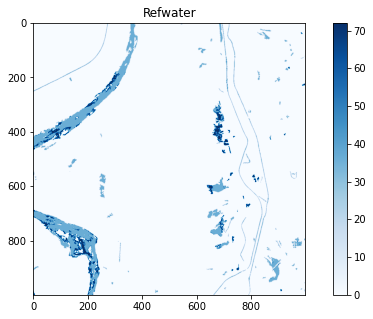

In [8]:
# really basic test to see if the results are actually as expected
import os
import xarray as xr
import matplotlib.pyplot as plt

path = "./gfm/refwater/"
files = [path + file for file in os.listdir(path) if file.startswith("AS") and "20220901" in file]
D = xr.open_mfdataset(files)
d = D.refwater
display(d)
plt.figure(figsize=(10,5))
plt.title(f"Refwater")
# only plot a part of the data
plt.imshow(d[5000:6000,5000:6000], cmap="Blues")
plt.colorbar()

In [19]:
spatial_extent  = {'west': 67.5, 'east':70, 'south':24.5, 'north':26}
temporal_extent = ["2022-09-01", "2022-10-01"] 
collection      = 'GFM'

gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["flood_extent", "refwater"]
)
gfm_sum = gfm_data.reduce_dimension(dimension="time", reducer=sum).reduce_dimension(dimension="bands", reducer=sum)

gfm_sum_nc = gfm_sum.save_result(format="NetCDF", options={"tile_grid": "equi7", "dtype": "int16"}) 

In [10]:
job = gfm_sum_nc.create_job(title = "UC11")
jobId = job.job_id
job.start_job()

<BatchJob job_id='b5452f5f-e133-4cd5-8daa-b5741d20fd74'>

In [14]:
job.status()

'finished'

In [15]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./gfm/sum/")

[PosixPath('gfm/sum/AS010M_E017N028T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E019N027T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E018N028T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E016N028T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E017N027T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E019N026T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E017N026T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E019N028T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E016N027T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E018N026T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E018N027T1_20220901T010907.nc'),
 PosixPath('gfm/sum/AS010M_E016N026T1_20220901T010907.nc'),
 PosixPath('gfm/sum/job-results.json')]

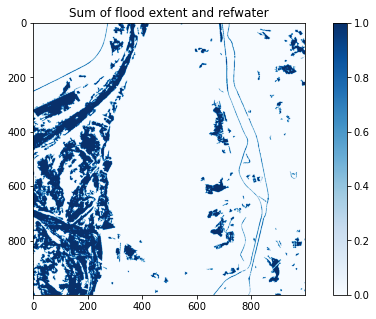

In [18]:
# really basic test to see if the results are actually as expected
import os
import xarray as xr
import matplotlib.pyplot as plt

path = "./gfm/sum/"
files = [path + file for file in os.listdir(path) if file.startswith("AS") and "20220901" in file]
D = xr.open_mfdataset(files)
d = D.name
# display(d)
plt.figure(figsize=(10,5))
plt.title(f"Sum of flood extent and refwater")
# only plot a part of the data
plt.imshow(d[5000:6000,5000:6000]!=0, cmap="Blues")
plt.colorbar()